In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

# set seed
torch.manual_seed(54)
torch.cuda.manual_seed(54)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# setup pretrained model

# weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# model instance
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 126MB/s]


In [ ]:
# get automatic transforms
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 2
classes = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3}
img_per_class = 1000


# load data
dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=True,
                                          download=True,
                                          transform=pretrained_vit_transforms)

# class indices
class_indices = {k:[] for k in classes.values()}

for idx, (img, label) in enumerate(dataset):
    if label in class_indices and len(class_indices[label]) < img_per_class:
        class_indices[label].append(idx)

    if all(len(num_indices)== img_per_class for num_indices in class_indices.values()):
        break

# create subset
total_indices = sum(class_indices.values(),[])
subset_dataset = Subset(dataset, total_indices)

# train and test split
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_data_pretrained, test_data_pretrained = random_split(subset_dataset, [train_size, test_size])


train_loader_pretrained = DataLoader(train_data_pretrained, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
test_loader_pretrained = DataLoader(test_data_pretrained, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

print(f'Train data size: {len(train_data_pretrained)} images, Test data size: {len(test_data_pretrained)} images')


100%|██████████| 170M/170M [00:03<00:00, 44.6MB/s]


Train data size: 3200 images, Test data size: 800 images


In [ ]:
train_loader_pretrained, test_loader_pretrained

(<torch.utils.data.dataloader.DataLoader at 0x781f3fe8ef90>,
 <torch.utils.data.dataloader.DataLoader at 0x781f3fe689d0>)

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(pretrained_vit, input_size = (1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
# freeze the base parameters

for parm in pretrained_vit.parameters():
    parm.requires_grad = False

# modify the classifier head
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = 4).to(device)

In [ ]:
summary(pretrained_vit, input_size = (1,3,224,224), col_names=("input_size","output_size","num_params","trainable"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [1, 3, 224, 224]          [1, 4]                    768                       Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder: 1-2                                [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout: 2-1                           [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential: 2-2                        [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             [1, 197, 768]  

In [ ]:
# get engine.py script from github
!git clone https://github.com/aashu-0/ml-paper-implementation
! mv ml-paper-implementation/ViT .
from ViT import engine

Cloning into 'ml-paper-implementation'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 28 (delta 7), reused 27 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 71.77 KiB | 5.98 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                            lr=0.0003,
                            betas = (0.9,0.99),
                            weight_decay = 0.5)

In [ ]:
# training
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_loader_pretrained,
                                      test_dataloader = test_loader_pretrained,
                                      optimizer= optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 0.8156 | train acc: 0.7775 | test loss: 0.4123 | test acc: 0.9507 | 
epoch: 2 | train loss: 0.3148 | train acc: 0.9591 | test loss: 0.2543 | test acc: 0.9688 | 
epoch: 3 | train loss: 0.2286 | train acc: 0.9697 | test loss: 0.2137 | test acc: 0.9736 | 
epoch: 4 | train loss: 0.2006 | train acc: 0.9747 | test loss: 0.1969 | test acc: 0.9760 | 
epoch: 5 | train loss: 0.1871 | train acc: 0.9762 | test loss: 0.1886 | test acc: 0.9736 | 
epoch: 6 | train loss: 0.1803 | train acc: 0.9772 | test loss: 0.1830 | test acc: 0.9784 | 
epoch: 7 | train loss: 0.1750 | train acc: 0.9759 | test loss: 0.1805 | test acc: 0.9724 | 
epoch: 8 | train loss: 0.1726 | train acc: 0.9803 | test loss: 0.1779 | test acc: 0.9808 | 
epoch: 9 | train loss: 0.1708 | train acc: 0.9775 | test loss: 0.1775 | test acc: 0.9772 | 
epoch: 10 | train loss: 0.1704 | train acc: 0.9775 | test loss: 0.1766 | test acc: 0.9784 | 


In [ ]:
# save model dict
torch.save(pretrained_vit.state_dict(), "pretrained-vit_cifar10.pth")
print("Model saved as pretrained-vit_cifar10.pth")

Model saved as pretrained-vit_cifar10.pth


In [ ]:
import os

file_name = "pretrained-vit_cifar10.pth"
file_size = os.path.getsize(file_name)

print(f"File Size in Bytes is: {file_size}")
print(f"File Size in MegaBytes is: {file_size / (1024 * 1024):.2f} MB")

File Size in Bytes is: 343269670
File Size in MegaBytes is: 327.37 MB


In [ ]:
import matplotlib.pyplot as plt

def save_plots(results, save_dir='.'):
    """Save loss and accuracy plots"""
    # Create plots directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results['train_acc'], label='Train Accuracy')
    plt.plot(results['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    print(f"Plots saved to {os.path.join(save_dir, 'training_metrics.png')}")

Plots saved to ./training_metrics.png


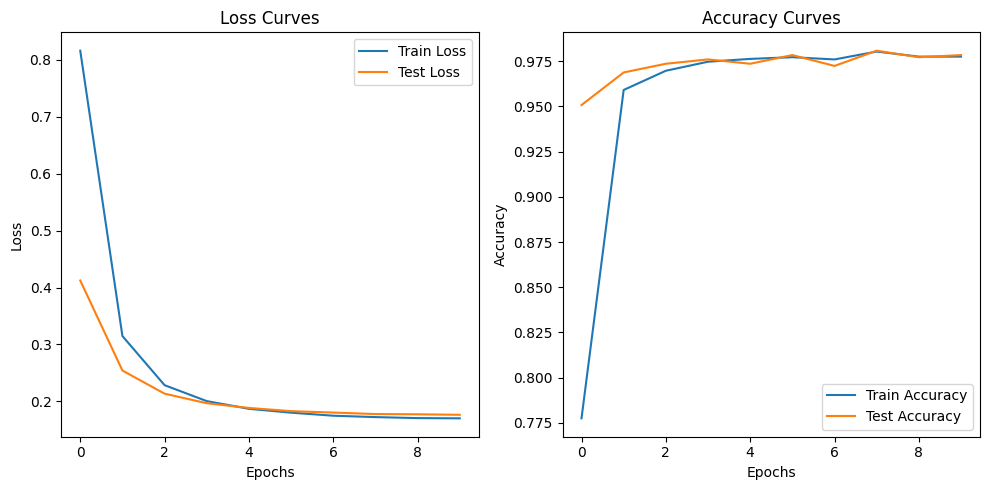

In [ ]:
save_plots(pretrained_vit_results)